# Employee Turnover
Problem Scenario

Portobello Tech is an app innovator who has devised an intelligent way of predicting employee turnover within the company. It periodically evaluates employees' work details, including the number of projects they worked on, average monthly working hours, time spent in the company, promotions in the last five years, and salary level. 

Data from prior evaluations shows the employees’ satisfaction in the workplace. The data could be used to identify patterns in work style and their interest in continuing to work for the company.  

The HR Department owns the data and uses it to predict employee turnover. Employee turnover refers to the total number of workers who leave a company over time. 

As the ML Developer assigned to the HR Department, you have been asked to create ML programs to: 

Perform data quality checks by checking for missing values, if any. 
Understand what factors contributed most to employee turnover at EDA. 
Perform clustering of employees who left based on their satisfaction and evaluation. 
Handle the left Class Imbalance using the SMOTE technique. 
Perform k-fold cross-validation model training and evaluate performance.  
Identify the best model and justify the evaluation metrics used.  
Suggest various retention strategies for targeted employees. 

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


# Load Dataset

satisfaction_level : Satisfaction level at the job of an employee

last_evaluation: Rating between 0 and 1, received by an employee at his last evaluation

number_project: The number of projects of an employee is involved in

average_monthly_hours: Average number of hours in a month spent by an employee at the office

time_spend_company: Number of years spent in the company

Work_accident: 0 - no accident during employee stay, 1-accident during employee stay

left: 0 indicates an employee stays with the company, 1 indicates an employee left the company

promotion_last_5years: Number of promotions in during stay

Department: Department to which an employee belongs to

salary: Salary in USD

In [31]:
df = pd.read_csv('HR_comma_sep.csv')
df.head(3)

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium


In [32]:
print(df.describe().T)

                         count        mean        std    min     25%     50%  \
satisfaction_level     14999.0    0.612834   0.248631   0.09    0.44    0.64   
last_evaluation        14999.0    0.716102   0.171169   0.36    0.56    0.72   
number_project         14999.0    3.803054   1.232592   2.00    3.00    4.00   
average_monthly_hours  14999.0  201.050337  49.943099  96.00  156.00  200.00   
time_spend_company     14999.0    3.498233   1.460136   2.00    3.00    3.00   
Work_accident          14999.0    0.144610   0.351719   0.00    0.00    0.00   
left                   14999.0    0.238083   0.425924   0.00    0.00    0.00   
promotion_last_5years  14999.0    0.021268   0.144281   0.00    0.00    0.00   

                          75%    max  
satisfaction_level       0.82    1.0  
last_evaluation          0.87    1.0  
number_project           5.00    7.0  
average_monthly_hours  245.00  310.0  
time_spend_company       4.00   10.0  
Work_accident            0.00    1.0  
left  

# Perform data quality checks by checking for missing values, if any. 

In [33]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_monthly_hours  14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB
None


In [34]:
def fill_miss(sample):   
    for col in sample:
        if sample[col].isnull().sum() == 0:
            print(f"No missing values in {col}")
        if sample[col].isnull().sum() > 0:
            mode_value = df[col].mode()
            print(f"Filling missing values in '{col}' with mean value: {mode_value:.2f}")
            sample[col].fillna(mode_value, inplace=True)
fill_miss(df)

No missing values in satisfaction_level
No missing values in last_evaluation
No missing values in number_project
No missing values in average_monthly_hours
No missing values in time_spend_company
No missing values in Work_accident
No missing values in left
No missing values in promotion_last_5years
No missing values in Department
No missing values in salary


In [35]:
for col in df.columns:
    num = (df[col] == '?').sum()
    print(f'Column "{col}" has {num} of "?" values')

Column "satisfaction_level" has 0 of "?" values
Column "last_evaluation" has 0 of "?" values
Column "number_project" has 0 of "?" values
Column "average_monthly_hours" has 0 of "?" values
Column "time_spend_company" has 0 of "?" values
Column "Work_accident" has 0 of "?" values
Column "left" has 0 of "?" values
Column "promotion_last_5years" has 0 of "?" values
Column "Department" has 0 of "?" values
Column "salary" has 0 of "?" values


# Understand what factors contributed most to employee turnover at EDA. 
## Draw a heatmap of the correlation matrix between all numerical features or columns in the data. 

In [36]:
num_col = df.select_dtypes(include=np.number)
num_col.rename(columns={'satisfaction_level': 'Satisfaction Level',
                           'last_evaluation': 'Last Evaluation', 
                           'number_project': 'Number of Projects', 
                           'average_monthly_hours': 'Average Monthly Hours', 
                           'time_spend_company': 'Time Spent with Company', 
                           'Work_accident': 'Experienced Work Accident', 
                           'left': 'Left Company',
                           'promotion_last_5years': 'Received Promotion in Last 5 Years'}, inplace=True)
# Renamed for easy of reading

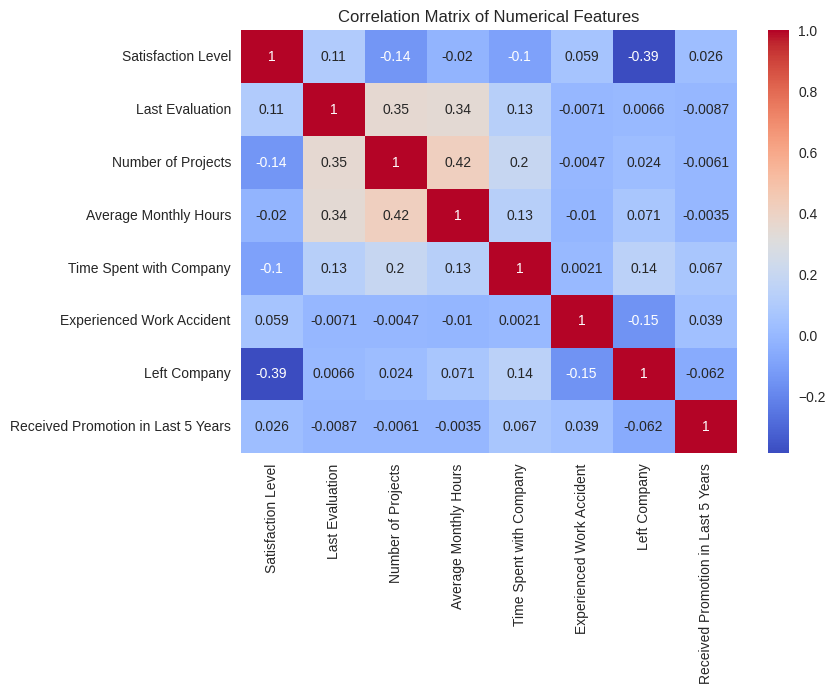

In [37]:
matrix = num_col.corr()
sns.heatmap(matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

### Observations
- Moderate correlation between number of projects and average monthly hours spent working, which makes sense as more working time is intuitively needed when you have more projects.
- Weak-moderate negative correlation between satisfaction level and leaving the company, suggesting the more unsatisfied an employee is, the more employees leave

## Draw the distribution plot of: 
Employee Satisfaction (use column satisfaction_level) 

Employee Evaluation (use column last_evaluation) 

Employee Average Monthly Hours (use column average_monthly_hours)

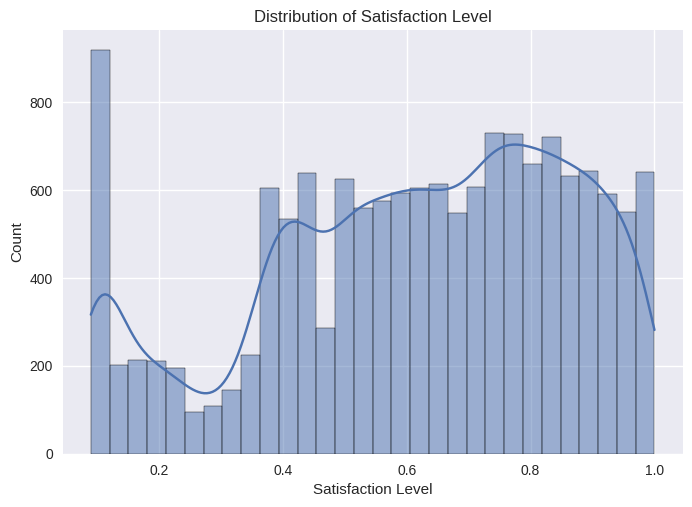

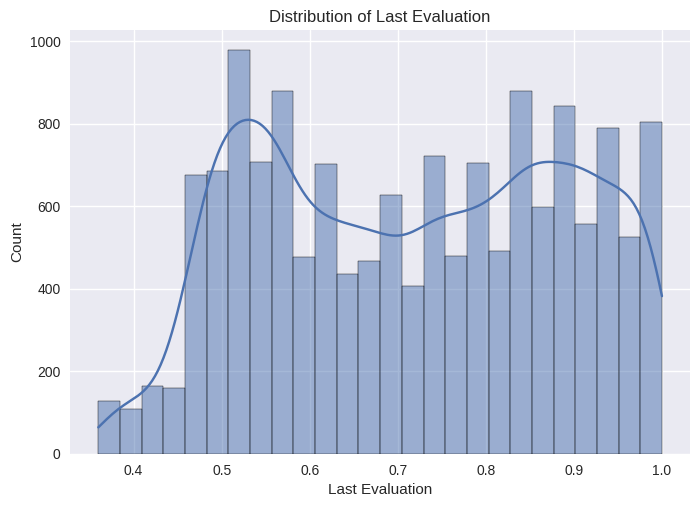

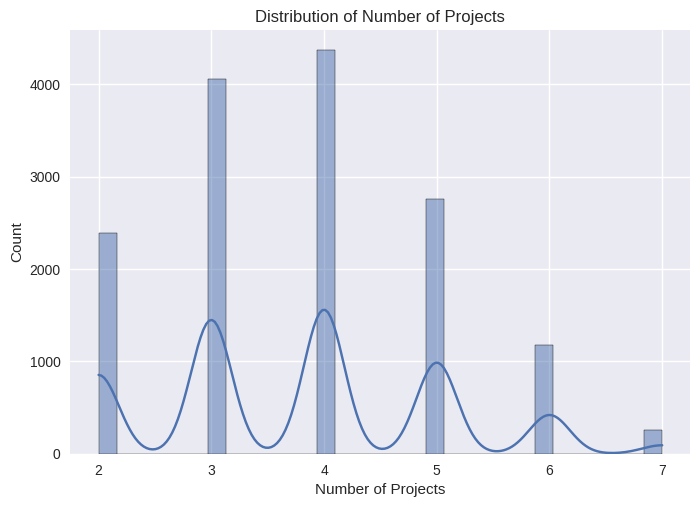

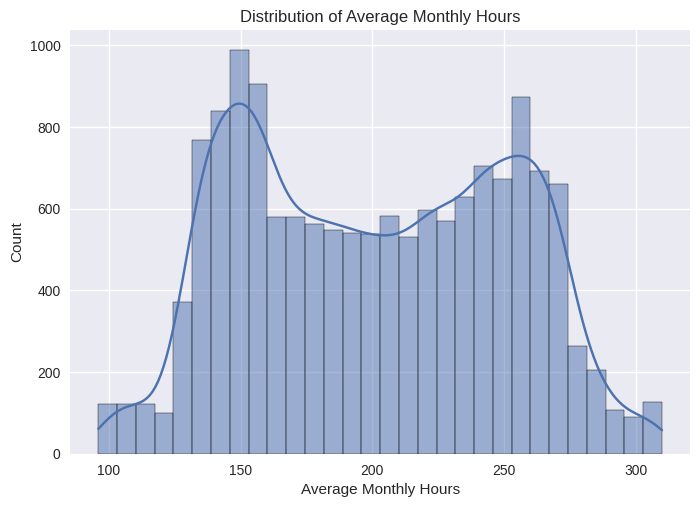

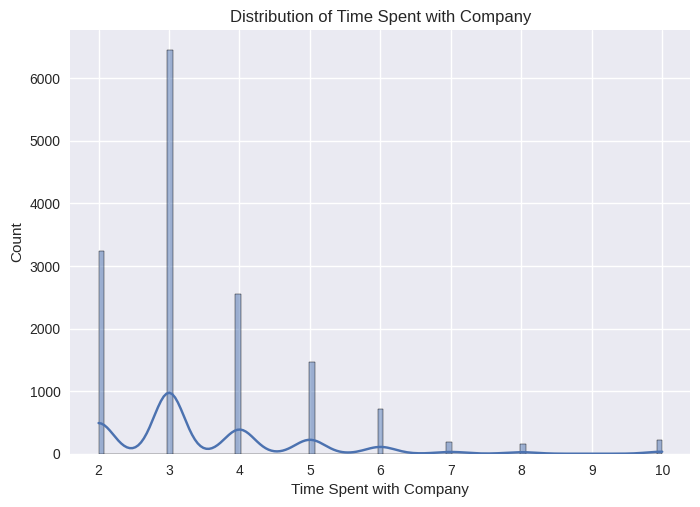

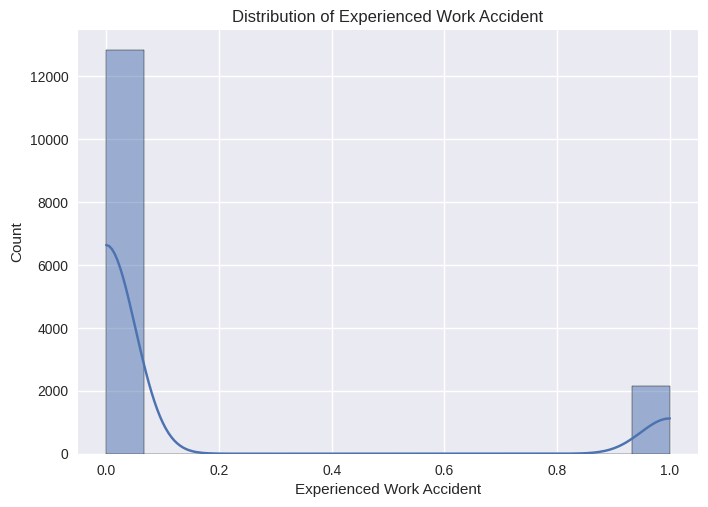

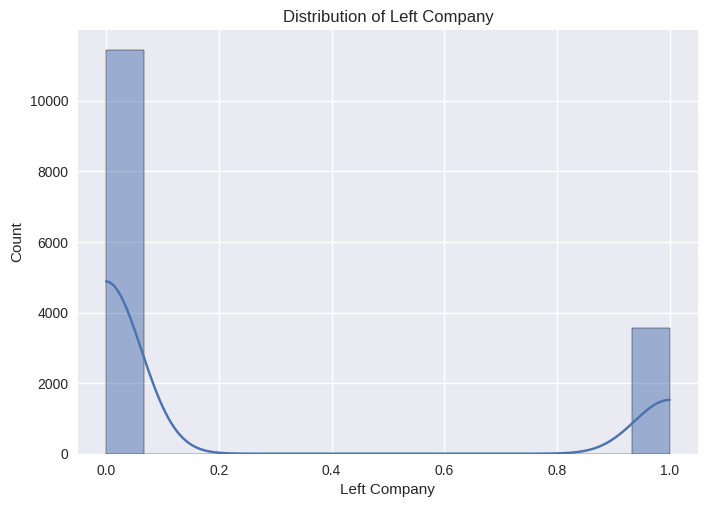

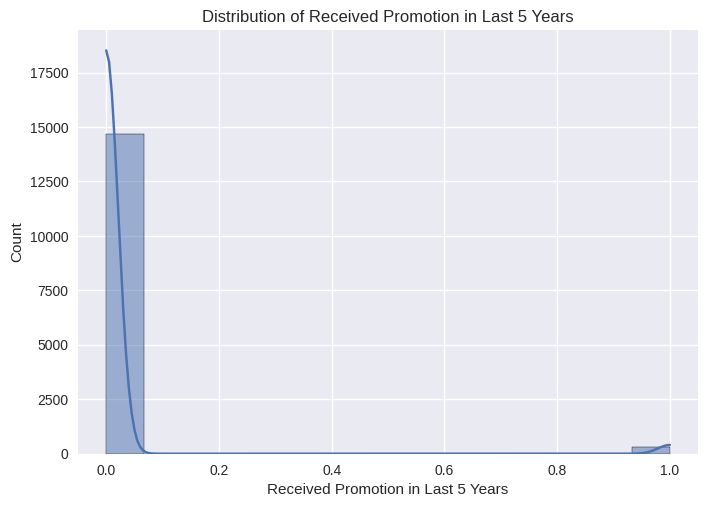

In [38]:
for col in num_col:
    plt.style.use('seaborn-v0_8')
    sns.histplot(num_col[col], bins='auto', kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

### Observations
- Majority of satisfaction level ratings are in the lowest tier
- Most often range of time spent with the company is 3 years

## Draw the bar plot of the employee project count of both employees who left and stayed in the organization (use column number_project and hue column left), and give your inferences from the plot.

In [39]:
left_data = num_col['Left Company'].copy()
left_data = left_data.map({0:'Stayed', 1: "Left"})

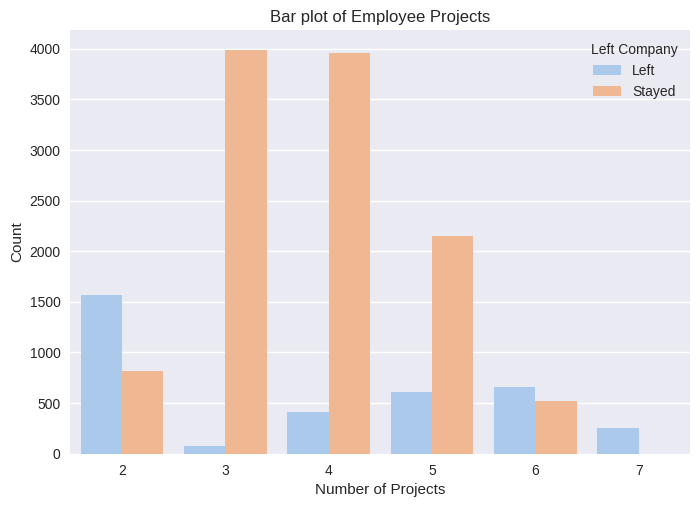

In [40]:
sns.countplot(x=num_col['Number of Projects'], hue=left_data, palette='pastel')
plt.title('Bar plot of Employee Projects')
plt.ylabel('Count')
plt.show()

### Observations
- Category of employees with 7 projects all left the company
- Most employees who left were in the 2 projects category
- Category of employees with 3 projects had the least amount of employees leaving

## Perform clustering of employees who left based on their satisfaction and evaluation. 
### Choose columns satisfaction_level, last_evaluation, and left. 


In [41]:
left_df = num_col[num_col['Left Company']==1]
left_df.sample(3)

,Satisfaction Level,Last Evaluation,Number of Projects,Average Monthly Hours,Time Spent with Company,Experienced Work Accident,Left Company,Received Promotion in Last 5 Years
281,0.27,0.56,3,301,3,0,1,0
14313,0.42,0.46,2,150,3,0,1,0
1793,0.43,0.51,2,143,3,0,1,0


In [42]:
X = left_df[['Satisfaction Level', 'Last Evaluation']]

### Do K-means clustering of employees who left the company into 3 clusters?

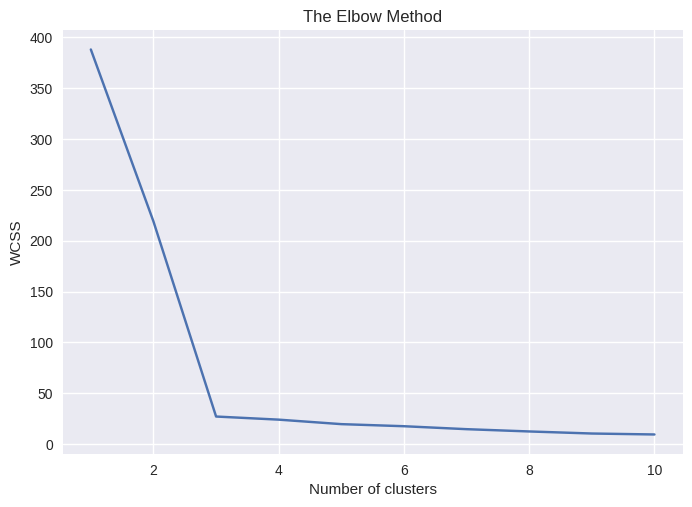

In [43]:
wcss = []
for i in range(1, 11):
    model = KMeans(n_clusters = i, random_state = 42)
    model.fit(X)
    wcss.append(model.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Elbow method has inflecion point at 3 clusters

/tmp/ipykernel_558/598188772.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_df['cluster'] = kmeans.fit_predict(X)


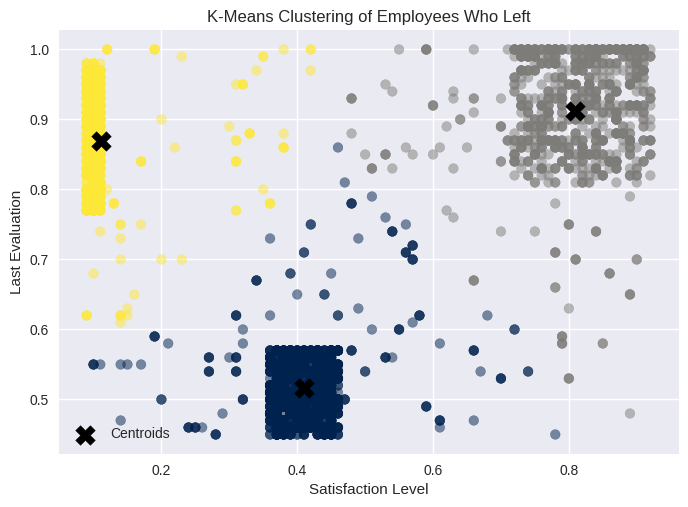

In [44]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
left_df['cluster'] = kmeans.fit_predict(X)
plt.scatter(left_df['Satisfaction Level'], left_df['Last Evaluation'], c=left_df['cluster'], cmap='cividis', alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', s=200, c='black', label='Centroids')

plt.xlabel('Satisfaction Level')
plt.ylabel('Last Evaluation')
plt.title('K-Means Clustering of Employees Who Left')
plt.legend()
plt.show()

#### Based on the satisfaction and evaluation factors, give your thoughts on the employee clusters. 

- There are 3 groups of clustering: Grey cluster with high evaluation and satisfaction level, Blue cluster with moderate evaluation and satisfaction level, and Yellow cluster with high evaluation and low satisfaction level. 
- Yellow cluster appears to have a disconnect between between the employee's satisfaction level, which is relatively low, and the how they are evaluated, which is relatively high.
- Blue cluster appears to be the most concentrated at it's centroid with the majority of data being centered in the middle of both evaluation and satisfaction level.

## Handle the left Class Imbalance using the SMOTE technique:
Pre-process the data by converting categorical columns to numerical columns by: 

### Separating categorical variables and numeric variables

In [45]:
num_col = df.select_dtypes(include=np.number)
cat_col = df.select_dtypes(exclude=np.number)

In [46]:
df.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_monthly_hours      int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
Department                object
salary                    object
dtype: object

### Applying get_dummies() to the categorical variables 

In [47]:
cat_col_encoded = pd.get_dummies(cat_col, drop_first=True, prefix='encode').astype(int)

### Combining categorical variables and numeric variables 

In [48]:
df = pd.concat([num_col, cat_col_encoded], axis =1)
df

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,left,promotion_last_5years,encode_RandD,encode_accounting,encode_hr,encode_management,encode_marketing,encode_product_mng,encode_sales,encode_support,encode_technical,encode_low,encode_medium
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,0,0,0,0,0,1,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,1,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,0,0,0,0,0,0,0,1,0,1,0
14995,0.37,0.48,2,160,3,0,1,0,0,0,0,0,0,0,0,1,0,1,0
14996,0.37,0.53,2,143,3,0,1,0,0,0,0,0,0,0,0,1,0,1,0
14997,0.11,0.96,6,280,4,0,1,0,0,0,0,0,0,0,0,1,0,1,0


Do the stratified split of the dataset to train and test in the ratio 80:20 with random_state=123. 

In [49]:
X = df.drop('left', axis=1)
y = df['left']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

Upsample the train dataset using the SMOTE technique from the imblearn module.

In [51]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

## Perform 5-fold cross-validation model training and evaluate performance. 
### Train a logistic regression model, apply a 5-fold CV, and plot the classification report. 

In [52]:
log_model = LogisticRegression(max_iter=1000, random_state=123)

# Perform 5-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
y_pred_log = cross_val_predict(log_model, X_train_smote, y_train_smote, cv=cv)
print(classification_report(y_train_smote,y_pred_log))

              precision    recall  f1-score   support

           0       0.81      0.77      0.78      9142
           1       0.78      0.82      0.80      9142

    accuracy                           0.79     18284
   macro avg       0.79      0.79      0.79     18284
weighted avg       0.79      0.79      0.79     18284



#### Classification Report for Logistic Model on Test data

In [53]:
# Performing model on testing data
log_model.fit(X_train_smote, y_train_smote)  
y_test_log_pred = log_model.predict(X_test)
print(classification_report(y_test,y_test_log_pred))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82      2286
           1       0.49      0.75      0.59       714

    accuracy                           0.75      3000
   macro avg       0.69      0.75      0.70      3000
weighted avg       0.80      0.75      0.77      3000



#### Confusion Matrix for Logistic Model

Logistic Confusion Matrix:


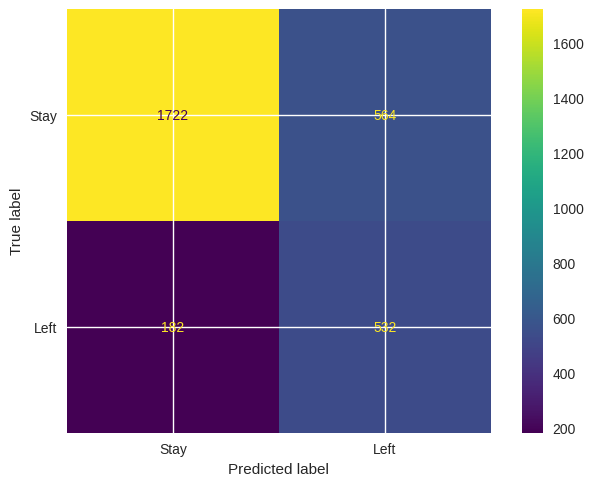

In [54]:
conf_matrix = confusion_matrix(y_test, y_test_log_pred)
print("Logistic Confusion Matrix:")
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ["Stay", "Left"])
cm_display.plot()
plt.show()

### Train a Random Forest Classifier model, apply the 5-fold CV, and plot the classification report. 

In [55]:
rf_model = RandomForestClassifier(random_state=123)
 
# Perform 5-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
y_pred_rf = cross_val_predict(rf_model, X_train_smote, y_train_smote, cv=cv)
print(classification_report(y_train_smote,y_pred_rf))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      9142
           1       0.99      0.97      0.98      9142

    accuracy                           0.98     18284
   macro avg       0.98      0.98      0.98     18284
weighted avg       0.98      0.98      0.98     18284



#### Classification report for Random Forest Classifier on Training Data

In [56]:
# Performing model on testing data
rf_model.fit(X_train_smote, y_train_smote) 
y_test_rf_pred = rf_model.predict(X_test)
print(classification_report(y_test,y_test_rf_pred)) 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2286
           1       0.98      0.98      0.98       714

    accuracy                           0.99      3000
   macro avg       0.98      0.99      0.98      3000
weighted avg       0.99      0.99      0.99      3000



#### Confusion matrix for Random Forest Classifier

Random Forest Confusion Matrix:


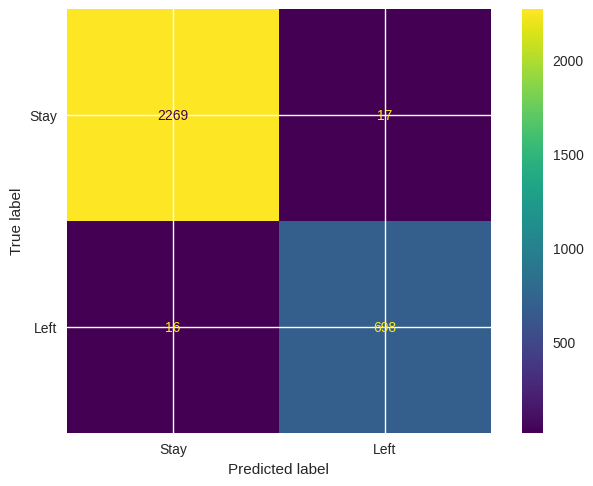

In [57]:
conf_matrix = confusion_matrix(y_test, y_test_rf_pred)
print("Random Forest Confusion Matrix:")
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ["Stay", "Left"])
cm_display.plot()
plt.show()

### Train a Gradient Boosting Classifier model, apply the 5-fold CV, and plot the classification report. 

In [58]:
GB_model = GradientBoostingClassifier(random_state=123) 

# Perform 5-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
y_pred_GB = cross_val_predict(GB_model, X_train_smote, y_train_smote, cv=cv)
print(classification_report(y_train_smote,y_pred_GB))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      9142
           1       0.97      0.94      0.96      9142

    accuracy                           0.96     18284
   macro avg       0.96      0.96      0.96     18284
weighted avg       0.96      0.96      0.96     18284



#### Classification report for Gradient Boosting Classifier on Testing Data

In [59]:
# Performing model on testing data
GB_model.fit(X_train_smote, y_train_smote) 
y_test_GB_pred = GB_model.predict(X_test)
print(classification_report(y_test,y_test_GB_pred))  # Evaluating on Test Set

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2286
           1       0.92      0.94      0.93       714

    accuracy                           0.97      3000
   macro avg       0.95      0.96      0.95      3000
weighted avg       0.97      0.97      0.97      3000



#### Confusion matrix for Gradient Boosting Classifier

Gradient Boost Confusion Matrix:


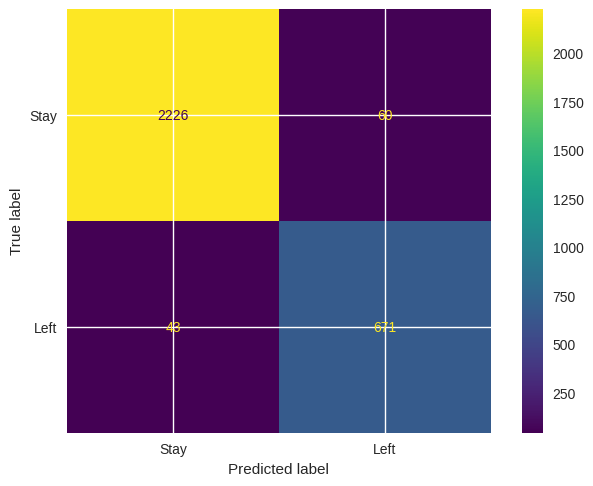

In [60]:
conf_matrix = confusion_matrix(y_test, y_test_GB_pred)
print("Gradient Boost Confusion Matrix:")
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ["Stay", "Left"])
cm_display.plot()
plt.show()


## Explain which metric needs to be used from the confusion matrix: Recall or Precision? 

Recall (Sensitivity) metrics would be the most important in this case to identify most "at-risk" employees of leaving. Since Recall takes into account the true positives and false negatives, the values of the two bottom quadrants of the confusion matrix can be used for analysis.

### Identify the best model and justify the evaluation metrics used.

Random Forest Classifier yields best f1 and accuracy scores compared to Logistic Regression and Gradient Boost classifier

### Find the ROC/AUC for each model and plot the ROC curve. 

#### Logistic Regression ROC/AUC

In [61]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_log_pred)
roc_auc = auc(fpr, tpr)

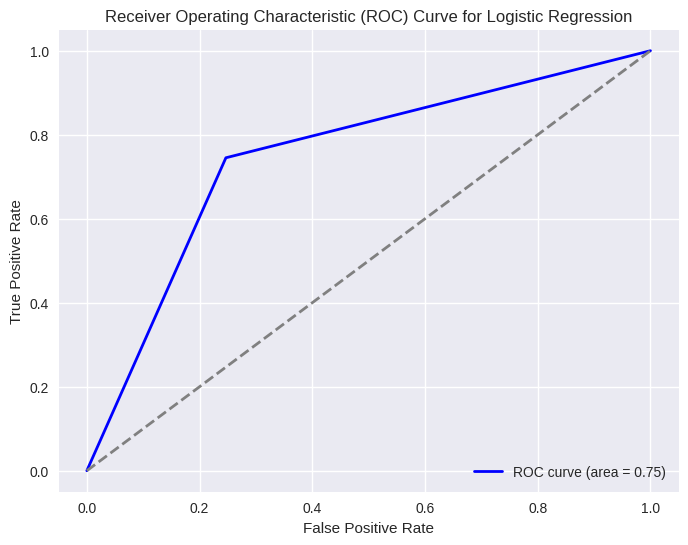

In [62]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.show()

#### Random Forest Classifier ROC/AUC

In [63]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_rf_pred)
roc_auc = auc(fpr, tpr)

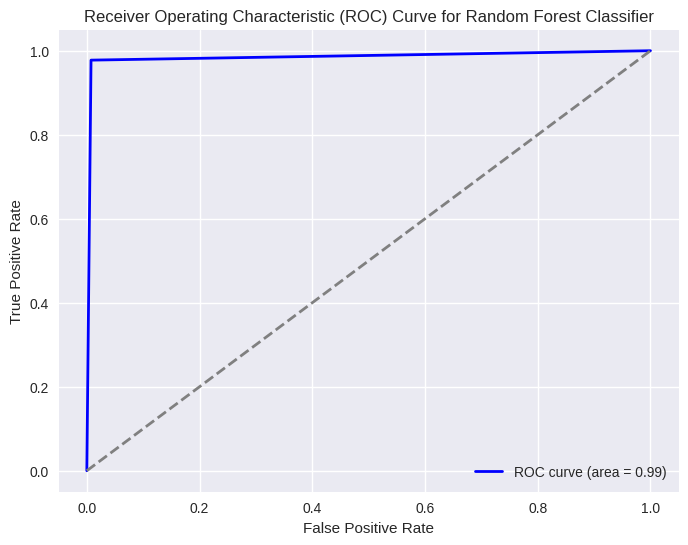

In [64]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest Classifier')
plt.legend(loc='lower right')
plt.show()

#### Gradient Boosting Classifier ROC/AUC

In [65]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_GB_pred)
roc_auc = auc(fpr, tpr)

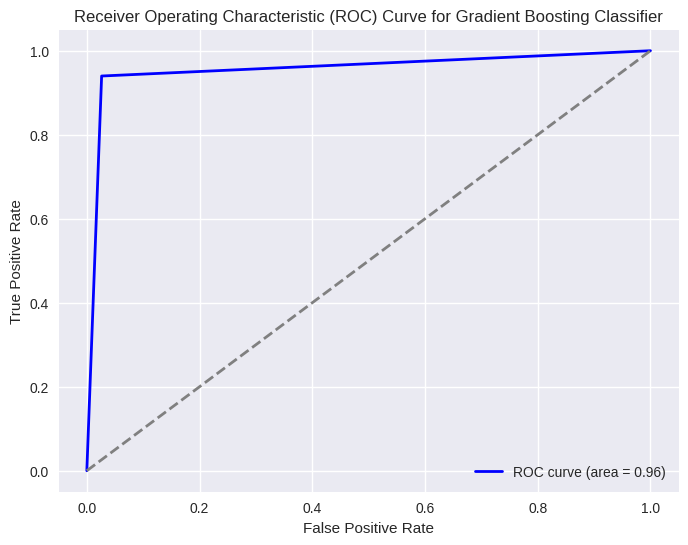

In [66]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Gradient Boosting Classifier')
plt.legend(loc='lower right')
plt.show()

## Using the best model, predict the probability of employee turnover in the test data. 

Based on the probability score range below, categorize the employees into four zones and suggest your thoughts on the retention strategies for each zone. 

In [67]:
leave_probability = rf_model.predict_proba(X_test)[:,1]
targeted_employee = pd.DataFrame({'Probability': leave_probability})

In [68]:
bin_edges = [0, 0.2, 0.6, 0.9, np.inf]
bin_labels = ['Safe Zone (Green)', 'Low-Risk Zone (Yellow)', 'Medium-Risk (Orange)', 'High-Risk (Red)']
targeted_employee['Risk Zone'] = pd.cut(targeted_employee['Probability'], bins=bin_edges, labels=bin_labels, right=False)
targeted_employee

,Probability,Risk Zone
0,0.00,Safe Zone (Green)
1,0.75,Medium-Risk (Orange)
2,0.09,Safe Zone (Green)
3,0.00,Safe Zone (Green)
4,0.02,Safe Zone (Green)
...,...,...
2995,0.00,Safe Zone (Green)
2996,0.04,Safe Zone (Green)
2997,0.04,Safe Zone (Green)
2998,0.04,Safe Zone (Green)


Risk Zone
Safe Zone (Green)         2145
High-Risk (Red)            662
Low-Risk Zone (Yellow)     148
Medium-Risk (Orange)        45
Name: count, dtype: int64


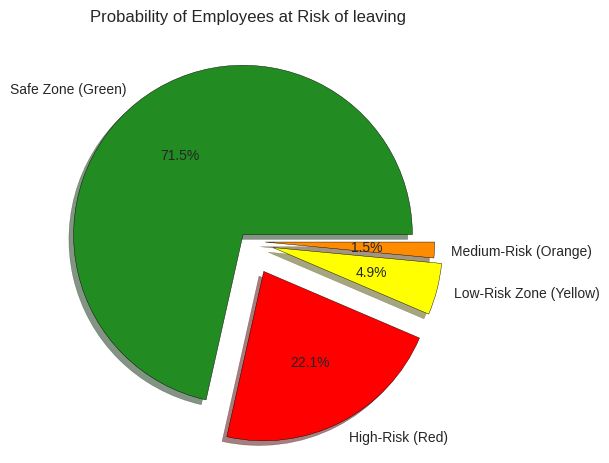

In [69]:
risk_count = targeted_employee['Risk Zone'].value_counts()
print(risk_count)
colors = ['forestgreen','red', 'yellow', 'darkorange']
plt.title('Probability of Employees at Risk of leaving')
plt.pie(risk_count, labels=risk_count.index, shadow=True, colors=colors, explode=(0.05, 0.20, 0.15, 0.1), autopct='%1.1f%%', wedgeprops={'edgecolor': 'black'})
plt.show()

# Suggest various retention strategies for targeted employees. 

Safe Zone (Green) (Score < 20%) 
- Investigate what factors are leading to the higher satisfaction levels
- Facilitate the "favorable culture" of those thriving in the Green zone 

Low-Risk Zone (Yellow) (20% < Score < 60%) 
- Find ways to help employees feel supported and empowered

Medium-Risk Zone (Orange) (60% < Score < 90%) 
- Scheduling one-on-one check-in meetings with manager to monitor positive or negative trend
- Emphasizing professional development and promotions for have more responsibility and financial incentive to stay with company

High-Risk Zone (Red) (Score > 90%).
- Investigating via one-on-one meetings with respective manager to discuss grievences/concerns as satisfaction levels have negative correlation with leaving company
- Reallocate workload to alleviate pressure on overworked employees and possibly decreasing average monthly hours and number of projects with weak positive correlation with leaving company